<a href="https://colab.research.google.com/github/shubhamprajapati1504/PNEUMONIA-DETECTION-SYSTEM-USING-CHEST-X-RAYS-DEEP-LEARNING-PROJECT/blob/main/Pneumonia_Detection_using_chest_X_Rays_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First install kagglehub if you haven't already
!pip install kagglehub

# Import and download the dataset
import kagglehub
import os

# Download the dataset
path = kagglehub.dataset_download("nih-chest-xrays/sample")

# Create a directory in Colab if it doesn't exist
!mkdir -p /content/dataset

# Move/Copy the files to your Colab directory
# The '!' allows running shell commands in Colab
!cp -r $path/* /content/dataset/

# Verify the files are copied
!ls /content/dataset

100%|██████████| 4.20G/4.20G [00:31<00:00, 145MB/s]

Extracting files...


sample	sample_labels.csv


In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from random import sample
import sklearn.model_selection as skl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import math

In [ ]:
!pip install pydot graphviz

In [6]:
# Read the CSV file
all_xray_df = pd.read_csv('/content/dataset/sample/sample_labels.csv')

# Correct the path for glob to match your directory structure
all_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('/content/dataset/sample/images', '*.png'))}

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

# Map the paths to the dataframe
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

# Display a sample
all_xray_df.sample(3)

Scans found: 5606 , Total Headers 5606


Image Index         Finding Labels  Follow-up #  Patient ID  \
1952  00010176_000.png  Fibrosis|Infiltration            0       10176   
3186  00015679_004.png            Atelectasis            4       15679   
417   00002212_002.png             No Finding            2        2212   

     Patient Age Patient Gender View Position  OriginalImageWidth  \
1952        073Y              M            PA                2500   
3186        064Y              M            AP                3056   
417         048Y              F            PA                2021   

      OriginalImageHeight  OriginalImagePixelSpacing_x  \
1952                 2048                     0.168000   
3186                 2528                     0.139000   
417                  2020                     0.194311   

      OriginalImagePixelSpacing_y  \
1952                     0.168000   
3186                     0.139000   
417                      0.194311   

                                                 path  
1952  /content/dataset/sample/images/00010176_000.png  
3186  /content/dataset/sample/images/00015679_004.png  
417   /content/dataset/sample/images/00002212_002.png

In [7]:
findings = set()
for f in all_xray_df['Finding Labels'].unique():
    findings.update(f.split('|'))
print(f'Total number of single diagnoses: {len(findings)}')
findings

Total number of single diagnoses: 15


{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

In [8]:
for finding in findings:
    all_xray_df[finding] = all_xray_df['Finding Labels'].str.contains(finding).astype(float)

all_xray_df.head(3)

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \
0                3056                 2544                        0.139  ...   
1                2500                 2048                        0.168  ...   
2                2500                 2048                        0.168  ...   

   Pneumonia Hernia  Consolidation  Infiltration  Cardiomegaly  Effusion  \
0        0.0    0.0            0.0           1.0           0.0       0.0   
1        0.0    0.0            0.0           0.0           1.0       0.0   
2        0.0    0.0            0.0           0.0           0.0       0.0   

   Pleural_Thickening  Nodule  No Finding  Pneumothorax  
0                 1.0     0.0         0.0           1.0  
1                 0.0     0.0         0.0           0.0  
2                 0.0     0.0         1.0           0.0  

[3 rows x 27 columns]

In [9]:
# Check if all findings have been converted to columns
all_findings = list(findings)
missing_findings = [f for f in all_findings if f not in all_xray_df.columns]
print("Missing findings:", missing_findings)

# List all original columns
original_cols = ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
                'Patient Age', 'Patient Gender', 'View Position',
                'OriginalImageWidth', 'OriginalImageHeight',
                'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y', 'path']
missing_orig = [col for col in original_cols if col not in all_xray_df.columns]
print("\nMissing original columns:", missing_orig)

# Print total columns and their names
print("\nTotal columns:", len(all_xray_df.columns))
print("\nAll columns:")
print(list(all_xray_df.columns))

Missing findings: []

Missing original columns: []

Total columns: 27

All columns:
['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth', 'OriginalImageHeight', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y', 'path', 'Emphysema', 'Atelectasis', 'Edema', 'Mass', 'Fibrosis', 'Pneumonia', 'Hernia', 'Consolidation', 'Infiltration', 'Cardiomegaly', 'Effusion', 'Pleural_Thickening', 'Nodule', 'No Finding', 'Pneumothorax']


In [10]:
# Validate binary encoding
def validate_encoding(row):
    findings_in_label = set(row['Finding Labels'].split('|'))
    for finding in findings:
        if (row[finding] == 1.0) != (finding in findings_in_label):
            return False
    return True

validation = all_xray_df.apply(validate_encoding, axis=1)
print("Incorrect encodings:", (~validation).sum())

Incorrect encodings: 0


In [11]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda x: 'Y' if x['Pneumonia'] == 1.0 else 'N', axis=1)
all_xray_df.head(3)

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \
0                3056                 2544                        0.139  ...   
1                2500                 2048                        0.168  ...   
2                2500                 2048                        0.168  ...   

   Hernia Consolidation  Infiltration  Cardiomegaly  Effusion  \
0     0.0           0.0           1.0           0.0       0.0   
1     0.0           0.0           0.0           1.0       0.0   
2     0.0           0.0           0.0           0.0       0.0   

   Pleural_Thickening  Nodule  No Finding  Pneumothorax  pneumonia_class  
0                 1.0     0.0         0.0           1.0                N  
1                 0.0     0.0         0.0           0.0                N  
2                 0.0     0.0         1.0           0.0                N  

[3 rows x 28 columns]

In [13]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.4 MB/s eta 0:00:00


In [27]:
import sklearn as skl
from random import sample
import pandas as pd

def create_splits(**vargs):
    """
    Create train and validation splits with exact specified ratios
    """
    df = vargs['df']

    # Initial split
    train_df, valid_df = skl.model_selection.train_test_split(df, test_size=0.2,
                                                             stratify=df['pneumonia_class'])

    # Calculate and print initial ratios
    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    print(f'Initial split. Train set pneumonia: {100.0*train_df_ratio:.2f}%. Valid set pneumonia: {100.0*valid_df_ratio:.2f}%')

    # Make training set 50/50
    train_pos_inds = train_df[train_df['pneumonia_class'] == 'Y'].index.tolist()
    train_neg_inds = train_df[train_df['pneumonia_class'] == 'N'].index.tolist()

    train_neg_sample = sample(train_neg_inds, len(train_pos_inds))
    train_df = train_df.loc[train_pos_inds + train_neg_sample]

    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    print(f'Train set corrected (50/50), pneumonia: {100.0*train_df_ratio:.2f}%')

    # Make validation set 20/80
    valid_pos_inds = valid_df[valid_df['pneumonia_class'] == 'Y'].index.tolist()
    valid_neg_inds = valid_df[valid_df['pneumonia_class'] == 'N'].index.tolist()

    valid_neg_sample = sample(valid_neg_inds, 4*len(valid_pos_inds))
    valid_df = valid_df.loc[valid_pos_inds + valid_neg_sample]

    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    print(f'Valid set corrected (20/80), pneumonia: {100.0*valid_df_ratio:.2f}%')

    return train_df, valid_df

# Example usage:
df_train, df_valid = create_splits(df=all_xray_df)
print(f'Train set size: {len(df_train)}, valid set size: {len(df_valid)}')

Initial split. Train set pneumonia: 1.12%. Valid set pneumonia: 1.07%
Train set corrected (50/50), pneumonia: 50.00%
Valid set corrected (20/80), pneumonia: 20.00%
Train set size: 100, valid set size: 60


In [28]:
# most common image size used for augmentation
IMAGE_SIZE = (224, 224)

def my_image_augmentation_train(**vargs):

    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations

    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data

    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package

    rotation = vargs['rotation'] if 'rotation' in vargs else 20
    shear = vargs['shear'] if 'shear' in vargs else 0.1
    zoom = vargs['zoom'] if 'rotation' in vargs else 0.1

    gen = ImageDataGenerator(
        rescale=1. / 255.0,
        horizontal_flip = True,
        vertical_flip = False,
        height_shift_range = 0.1,
        width_shift_range = 0.1,
        rotation_range = rotation,
        shear_range = shear,
        zoom_range = zoom)

    return gen


def make_train_gen(**vargs):

    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:

    df = vargs['df']

    aug = my_image_augmentation_train(**vargs)

    train_gen = aug.flow_from_dataframe(
        dataframe = df,
        directory = None,
        x_col = 'path',
        y_col = 'pneumonia_class',
        class_mode = 'binary',
        target_size = IMAGE_SIZE,
        batch_size = 32)

    return train_gen


def my_image_augmentation_valid(**vargs):

    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations

    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data

    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package

#     rotation = vargs['rotation'] if 'rotation' in vargs else 20
#     shear = vargs['shear'] if 'shear' in vargs else 0.1
#     zoom = vargs['zoom'] if 'rotation' in vargs else 0.1

    gen = ImageDataGenerator(rescale=1. / 255.0)

    return gen

def make_valid_gen(**vargs):

    df = vargs['df']

    aug = my_image_augmentation_valid(**vargs)

    valid_gen = aug.flow_from_dataframe(
        dataframe = df,
        directory = None,
        x_col = 'path',
        y_col = 'pneumonia_class',
        class_mode = 'binary',
        target_size = IMAGE_SIZE,
        batch_size = 1024)

    return valid_gen

In [29]:
train_gen = make_train_gen(df = df_train)
valid_gen = make_valid_gen(df = df_valid)

Found 100 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.


In [30]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = valid_gen.next()

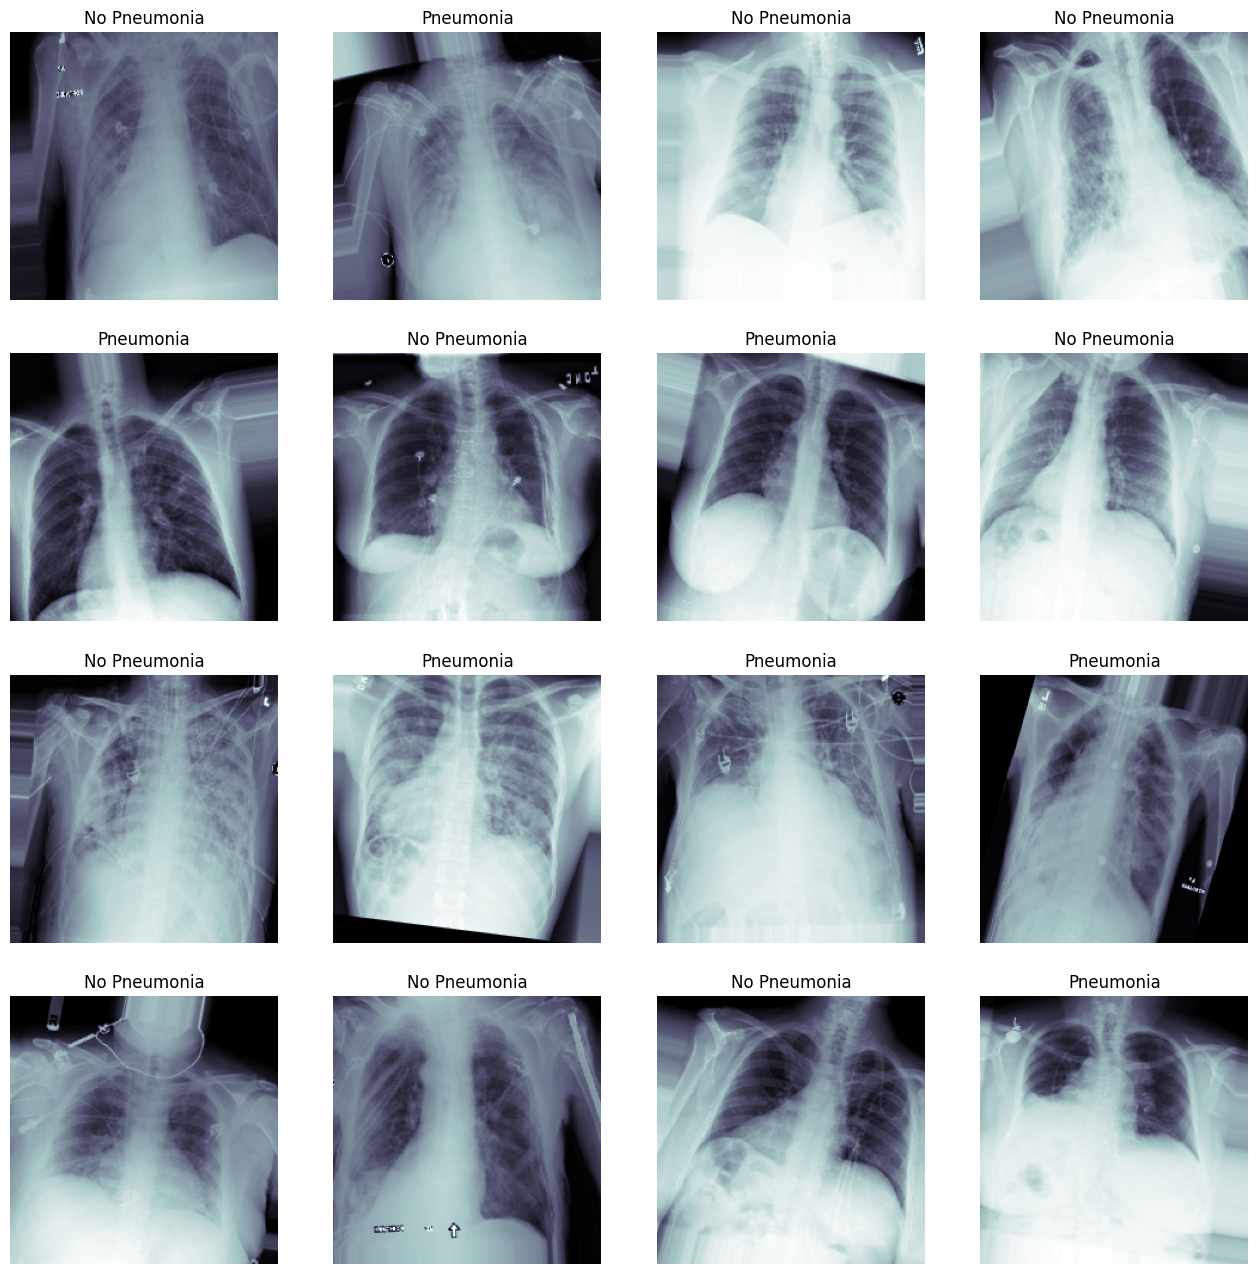

In [31]:
## May want to look at some examples of our augmented training data.
## This is helpful for understanding the extent to which data is being manipulated prior to training,
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1:
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

plt.show()

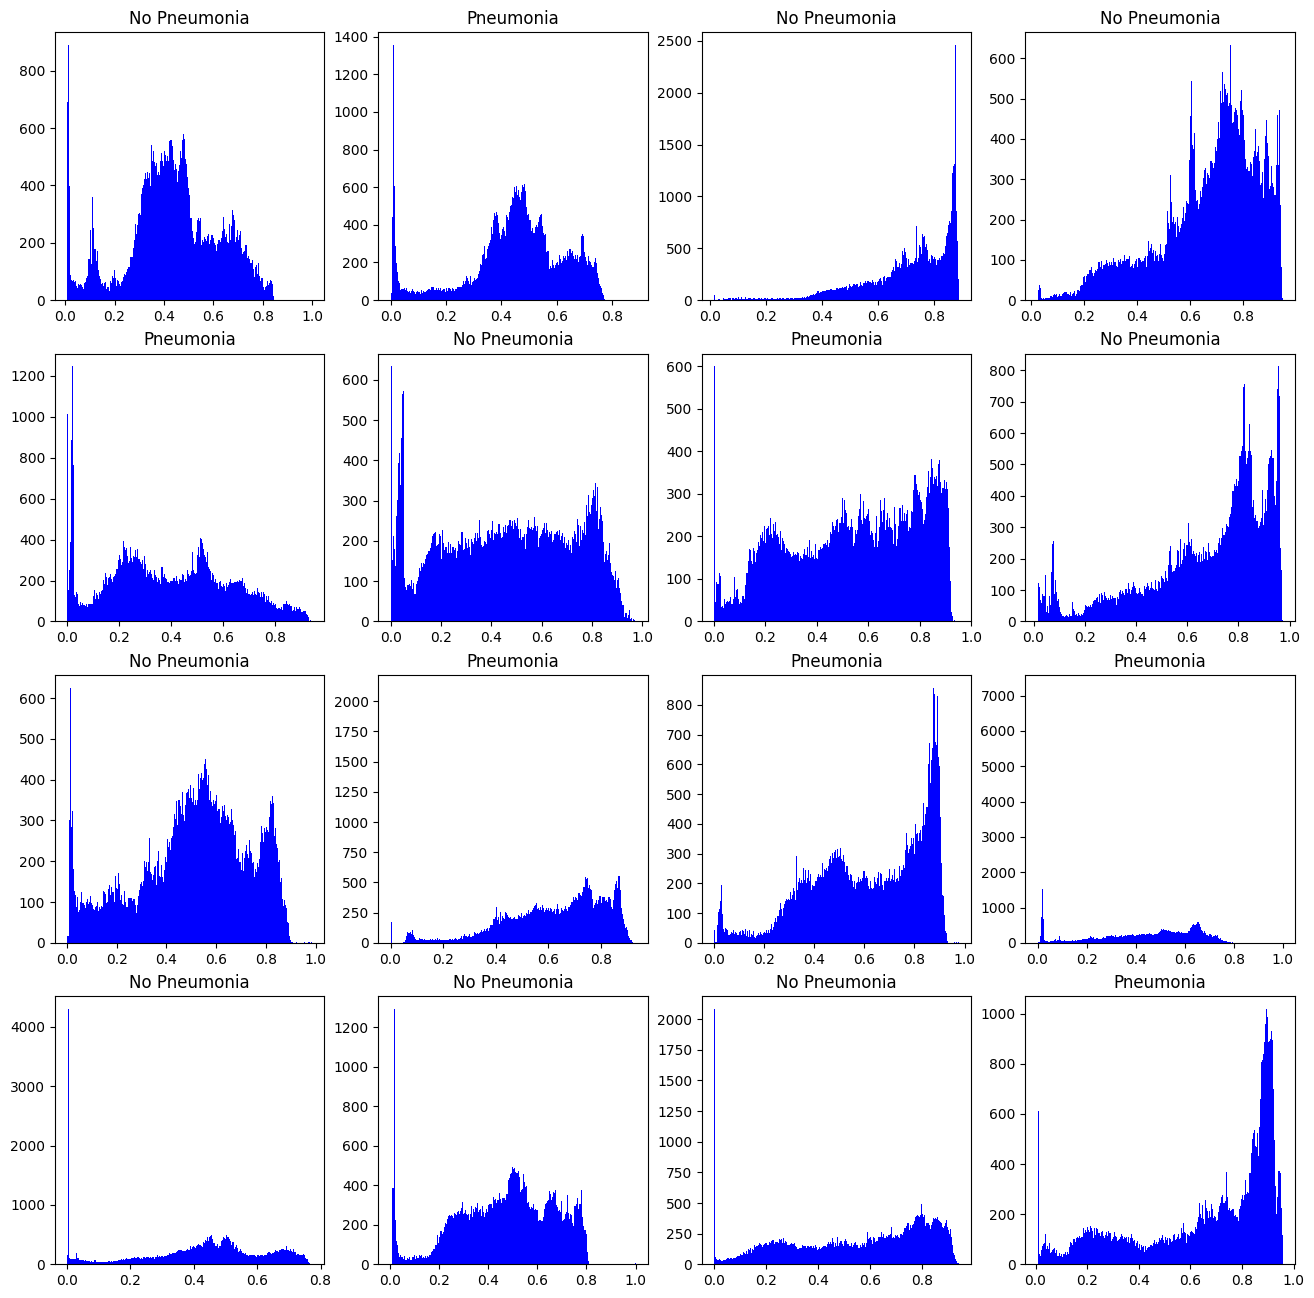

In [32]:
# t_x, t_y = next(train_gen)

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     mask = (data > 0.1) & (data < 0.9)
#     d = data[mask].flatten()
    c_ax.hist(c_x[:,:,0].flatten(), bins = 256, color='blue')

    if c_y == 1:
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')

plt.show()

In [33]:
def load_pretrained_model(**vargs):

    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)

    # trainable
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False

    print('VGG16 layers:')
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)

    return vgg_model

In [34]:
def build_my_model(**vargs):

    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)

    # if you want to compile your model within this function, consider which layers of your pre-trained model,
    # you want to freeze before you compile

    # also make sure you set your optimizer, loss function, and metrics to monitor

    # learning_rate = vargs['learning_rate'] if 'learning_rate' in vargs else 1e-4

    vgg_model = load_pretrained_model()

    new_model = Sequential()
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    new_model.add(Flatten())
    new_model.add(Dropout(0.2))
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.2))
#     new_model.add(Dense(1, activation='relu'))

    new_model.add(Dense(1, activation='sigmoid'))

    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [35]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code.
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_model.best.hdf5".format('xray_classification')

# checkpoint = ModelCheckpoint(
#     weight_path,
#     monitor = CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE
#     verbose = 1,
#     save_best_only = True,
#     mode = #CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC
#     save_weights_only = True)

# early = EarlyStopping(
#     monitor = #SAME_AS_METRIC_CHOSEN_ABOVE
#     mode = #CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC
#     patience=5)

# callbacks_list = [checkpoint, early]

In [36]:
model = build_my_model()
model.summary()

553467096/553467096 [==============================] - 2s 0us/step
VGG16 layers:
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)        

In [37]:
# define learning rate, loss, metrics and compile
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# define callbacks
weight_path="{}_model.best.hdf5".format('xray_classification')
checkpoint = ModelCheckpoint(weight_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True, save_weights_only = True)
early = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=10)
callbacks_list = [checkpoint, early]

# train your model
history = model.fit_generator(
    train_gen,
    validation_data = (valX, valY),
    epochs = 100,
    callbacks = callbacks_list)

<ipython-input-37-8df169d0181a>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 3.2886 - binary_accuracy: 0.4200
Epoch 1: val_loss improved from inf to 0.49538, saving model to xray_classification_model.best.hdf5
4/4 [==============================] - 7s 1s/step - loss: 3.2886 - binary_accuracy: 0.4200 - val_loss: 0.4954 - val_binary_accuracy: 0.8000
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.8294 - binary_accuracy: 0.4700
Epoch 2: val_loss did not improve from 0.49538
4/4 [==============================] - 5s 2s/step - loss: 0.8294 - binary_accuracy: 0.4700 - val_loss: 0.8045 - val_binary_accuracy: 0.2000
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.7320 - binary_accuracy: 0.4800
Epoch 3: val_loss did not improve from 0.49538
4/4 [==============================] - 5s 1s/step - loss: 0.7320 - binary_accuracy: 0.4800 - val_loss: 0.7423 - val_binary_accuracy: 0.2000
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 0.7196 - binary_acc

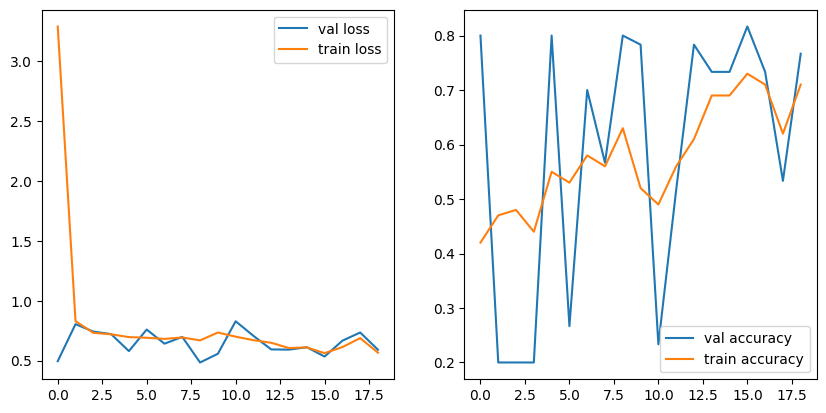

In [38]:
f = plt.figure()
f.set_figwidth(10)
f.add_subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.legend()

f.add_subplot(1, 2, 2)
plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
plt.plot(history.history['binary_accuracy'], label='train accuracy')
plt.legend()

plt.show()

In [39]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists,
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

2/2 [==============================] - 1s 503ms/step


In [40]:
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.show()

## what other performance statistics do you want to include here besides AUC?

def plot_pr(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='red', lw=2)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)


# Also consider plotting the history of your model training:

def plot_history(history):
    return

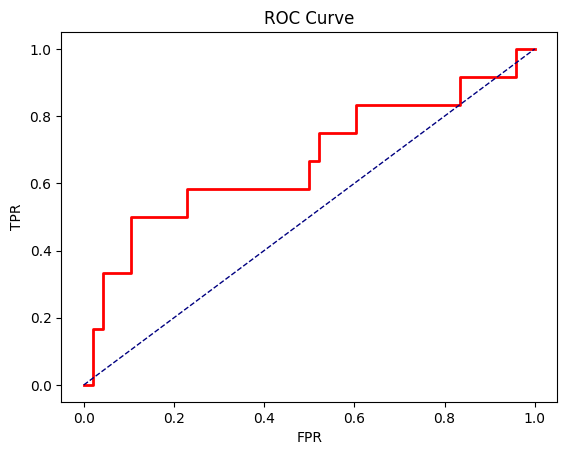

In [41]:
## plot figures
plot_auc(valY, pred_Y)

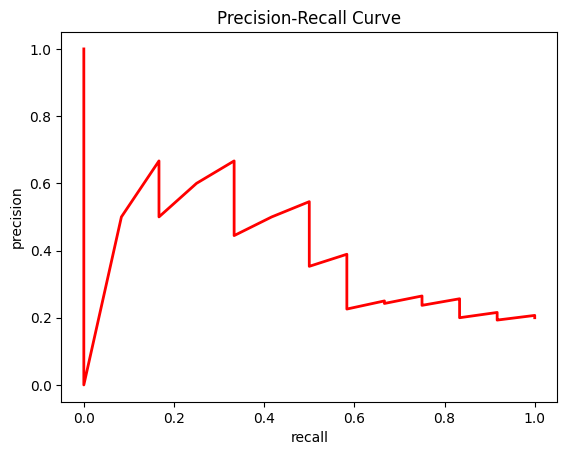

In [42]:
plot_pr(valY, pred_Y)

Text(0.5, 1.0, 'Precision/Recall by threshold')

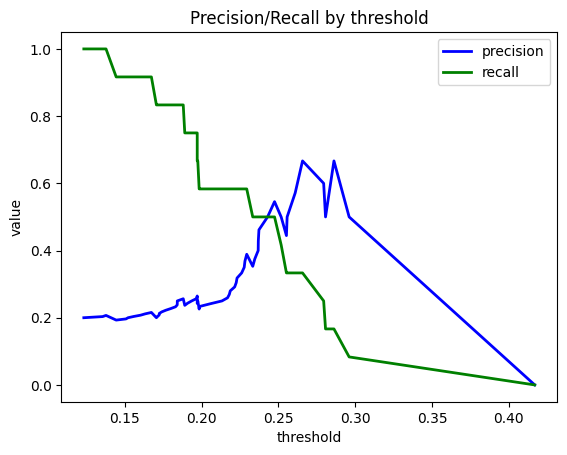

In [43]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y, pos_label=1)
plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('Precision/Recall by threshold')

<ipython-input-40-e8b64b854d7f>:21: RuntimeWarning: invalid value encountered in scalar divide
  return 2*(prec*recall)/(prec+recall)


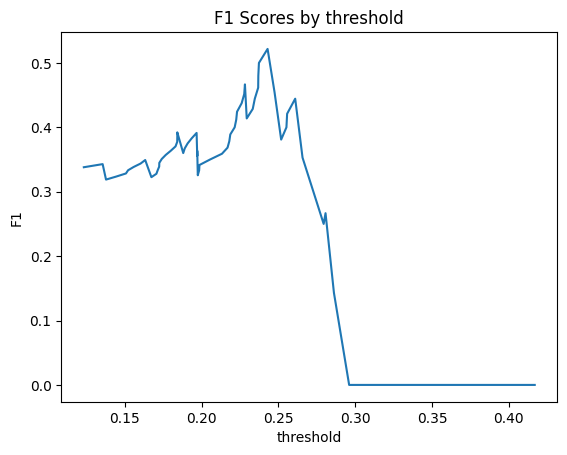

In [44]:
th = 0.5

def f1(threshold):
    for i,t in enumerate(thresholds):
        if t > threshold:
            f1score = calc_f1(precision[i], recall[i])
            if not math.isnan(f1score):
                return f1score
            else:
                return 0
    return 0

f1scores = [f1(t) for t in thresholds]
plt.plot(thresholds, f1scores)
plt.title('F1 Scores by threshold')
plt.xlabel('threshold')
plt.ylabel('F1')
plt.show()

In [45]:
ind = np.argmax(np.array(f1scores, dtype=np.float32))
f1 = f1scores[ind]
print(f'Max F1 score: {f1 :.3f}, threshold: {thresholds[ind] :.3f}, precision: {precision[ind] :.3f}, recall: {recall[ind] :.3f}')

Max F1 score: 0.522, threshold: 0.243, precision: 0.500, recall: 0.500


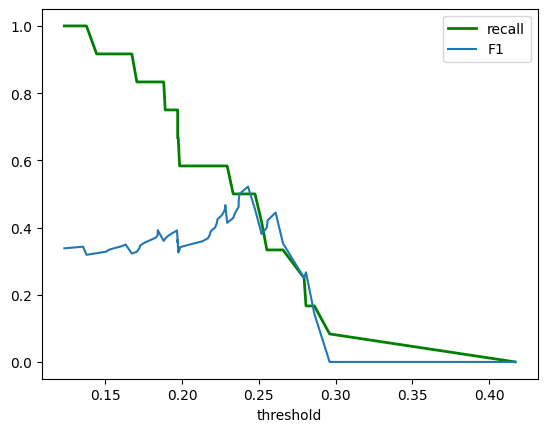

In [46]:
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.plot(thresholds, f1scores, label='F1')
plt.xlabel('threshold')
plt.legend()
plt.show()

In [49]:
def get_index(th):
    for i,t in enumerate(thresholds):
        if t > th:
            return i

print(f'Recall: {recall[get_index(0.25)] :.3f}, precision: {precision[get_index(0.25)] :.3f}, F1: {f1scores[get_index(0.25)] :.3f}, threshold: {thresholds[get_index(0.25)] :.3f}')
print(f'Recall: {recall[get_index(0.26)] :.3f}, precision: {precision[get_index(0.26)] :.3f}, F1: {f1scores[get_index(0.26)] :.3f}, threshold: {thresholds[get_index(0.26)] :.3f}')
print(f'Recall: {recall[get_index(0.27)] :.3f}, precision: {precision[get_index(0.27)] :.3f}, F1: {f1scores[get_index(0.27)] :.3f}, threshold: {thresholds[get_index(0.27)] :.3f}')
print(f'Recall: {recall[get_index(0.28)] :.3f}, precision: {precision[get_index(0.28)] :.3f}, F1: {f1scores[get_index(0.28)] :.3f}, threshold: {thresholds[get_index(0.28)] :.3f}')
print(f'Recall: {recall[get_index(0.29)] :.3f}, precision: {precision[get_index(0.29)] :.3f}, F1: {f1scores[get_index(0.29)] :.3f}, threshold: {thresholds[get_index(0.29)] :.3f}')

Recall: 0.417, precision: 0.500, F1: 0.381, threshold: 0.252
Recall: 0.333, precision: 0.571, F1: 0.444, threshold: 0.261
Recall: 0.250, precision: 0.600, F1: 0.250, threshold: 0.279
Recall: 0.167, precision: 0.500, F1: 0.267, threshold: 0.281
Recall: 0.083, precision: 0.500, F1: 0.000, threshold: 0.296


In [50]:
tn, fp, fn, tp = confusion_matrix(valY, (pred_Y > 0.3).astype(int)).ravel()
tn, fp, fn, tp

(47, 1, 12, 0)

In [51]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

YOUR_THRESHOLD = 0.3
testY = valY

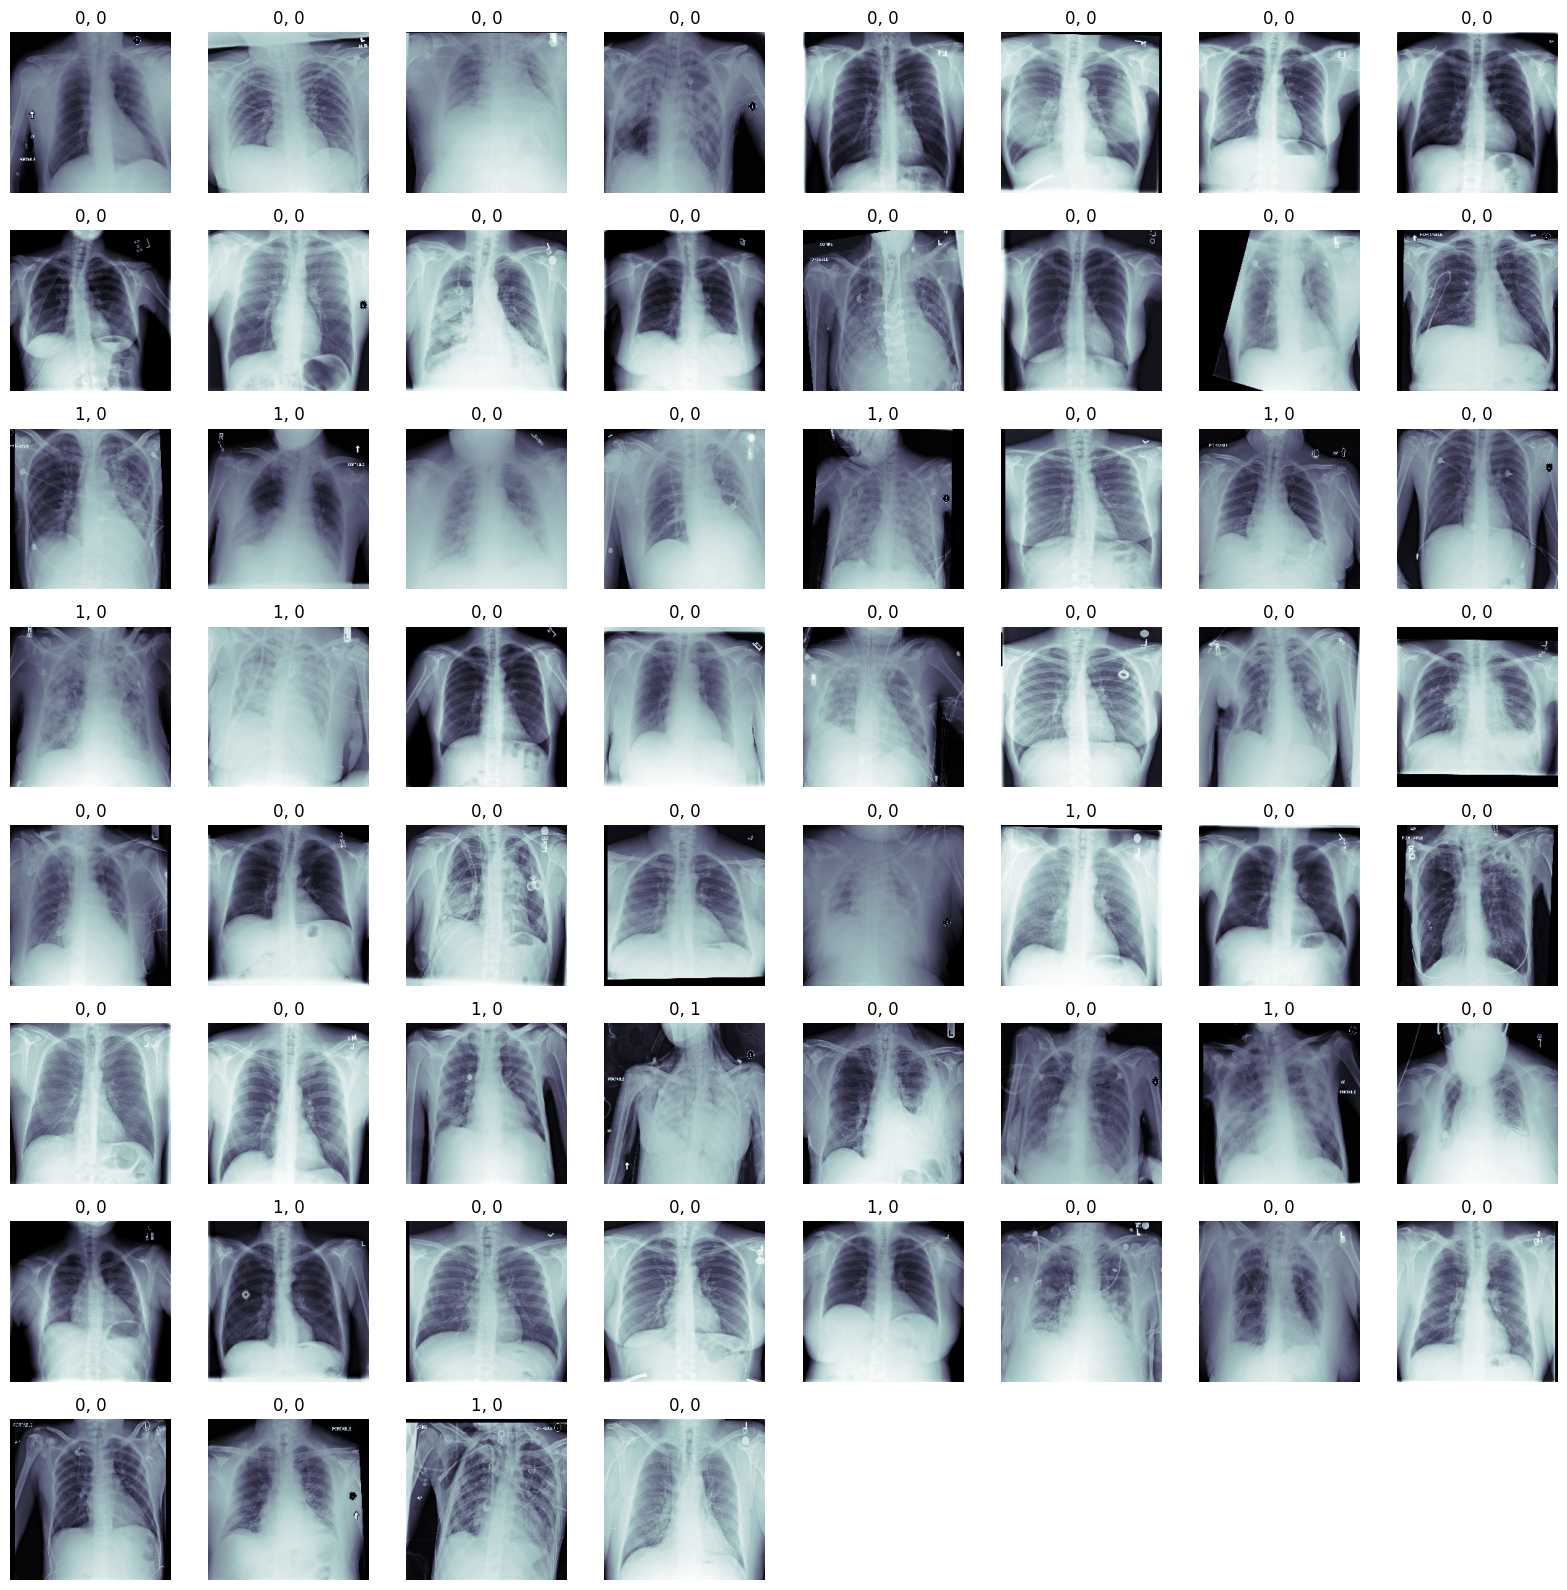

In [56]:
# Calculate number of images to display
n_images = len(valX[0:100])
n_rows = int(np.ceil(np.sqrt(n_images)))
n_cols = n_rows

# Create subplot grid based on actual number of images
fig, m_axs = plt.subplots(n_rows, n_cols, figsize=(16, 16))
i = 0

# Flatten axis array for easier iteration
for idx, (c_x, c_y, c_ax) in enumerate(zip(valX[0:n_images], testY[0:n_images], m_axs.flatten())):
    if idx < n_images:  # Only process if we have an image
        c_ax.imshow(c_x[:,:,0], cmap='bone')
        if c_y == 1:
            if pred_Y[i] > YOUR_THRESHOLD:
                c_ax.set_title('1, 1')
            else:
                c_ax.set_title('1, 0')
        else:
            if pred_Y[i] > YOUR_THRESHOLD:
                c_ax.set_title('0, 1')
            else:
                c_ax.set_title('0, 0')
    c_ax.axis('off')
    i += 1

# Hide empty subplots
for idx in range(n_images, n_rows * n_cols):
    m_axs.flatten()[idx].set_visible(False)

plt.tight_layout()

In [57]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("xray_final_model.json", "w") as json_file:
    json_file.write(model_json)